This notebook shows how to build a model to classify text with PyTorch and torchtext libraries.

It is based on the TREC-6 dataset, which consists on 5,952 questions written in English, classified in the following categories, depending on their answer:

* HUM: Human
* DESC: Description
* ABBR: Abbreviation
* LOC: Location
* NUM: Number
* ENTY: Entity

Author: manuelsh (https://github.com/manuelsh)

In [1]:
import torchtext
from torchtext import data, datasets
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print('Torchtext version used:',torchtext.__version__)
print('PyTorch version used:', torch.__version__)

Torchtext version used: 0.3.1
PyTorch version used: 0.4.1


# 1 - Data preparation

In [3]:
# Get datasets
text_field = data.Field(lower=True, batch_first=True, tokenize='spacy')
label_field = data.Field(sequential=False, unk_token = None)
train, test = datasets.TREC.splits(text_field, label_field)

print('Train length:',str(len(train)))
print('Test length:',str(len(test)))

Train length: 5452
Test length: 500


In [4]:
# Show some examples

for i in range(10):
    random_index = random.randint(0,len(train))
    print(' '.join(train.examples[random_index].text), train.examples[random_index].label)

what city 's airport is named logan international ? LOC
what is the definition of the term `` weapons system '' ? DESC
how many people in america snore ? NUM
how do you determine heating requirements for your home ? DESC
who killed more people , hitler or stalin ? HUM
who banned peter rose from baseball for betting on games ? HUM
how many horses are there on a polo team ? NUM
what capital is built around monument circle which contains soldiers and sailors monument ? LOC
what member of the little rascals has an on - again , off - again sweetheart in darla hood ? HUM
what is usenet for the internet ? DESC


In [5]:
# Build vocabulary
vocab_length = 5000
text_field.build_vocab(train, max_size=vocab_length )
label_field.build_vocab(train)

classes_count = len(label_field.vocab)
word_count = len(text_field.vocab)
print('Vocabulary length:',word_count )
print('Number of classes:',classes_count )

# Show vocabulary with: text_field.vocab.stoi

Vocabulary length: 5002
Number of classes: 6


# 2 - Build model

Using a simple model with an embedding, an LSTM and a linear layer. Note that the classical softmax layer for a classification model is already inside the CrossEntropyLoss function.

In [6]:
class RNN(nn.Module):
    def __init__(self, num_tokens, embedding_dim, rnn_dim, num_layers, num_classes):
        super(RNN, self).__init__()
        self.embeddings = nn.Embedding(num_tokens, embedding_dim)
        self.rnn = nn.LSTM(input_size = embedding_dim,
                           hidden_size = rnn_dim, 
                           num_layers = num_layers,
                           batch_first = True)
        self.linear = nn.Linear(rnn_dim, num_classes)

    def forward(self, x):
        emb = self.embeddings(x)
        rnn_output, rnn_hidden = self.rnn(emb)
        output = self.linear(rnn_output[:,-1,:])
        return output


n_hidden = 128
model = RNN(word_count, embedding_dim=128, rnn_dim=128, num_layers=1, num_classes=classes_count)
model

RNN(
  (embeddings): Embedding(5002, 128)
  (rnn): LSTM(128, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=6, bias=True)
)

# 3 - Objective function (and optimizer)

In [7]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # Scheduled learnint rate, which decays the
                                                                         # learning rate exponentially. This could
                                                                         # potentially help arrive to a lower minimum.
# Another option could be:
#lr_decay = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, factor=0.95, patience=10 )

# 4 - Train model (and test during training)

In [8]:
batch_size = 32
num_epochs = 5

train_iter = data.BucketIterator(train, 
                                 batch_size=batch_size, 
                                 sort_within_batch=True, 
                                 shuffle = True, 
                                 repeat = False)

test_iter = data.BucketIterator(test, 
                          batch_size=30, 
                          sort_within_batch=True, 
                          shuffle = True, 
                          repeat = False)

In [9]:
# Reset variables 
accuracies = []
losses_train = []
losses_test = []
train_accuracy = 0
step_count = 0
max_accuracy = 0

In [10]:
# Training loop
for i in range(num_epochs):
    print('Training epoch ',i)
    train_iter.init_epoch()
    for batch in train_iter:        

        x_train = batch.text
        y_train = batch.label

        # Forward pass
        y_model = model(x_train)

        # Loss function
        loss = loss_function(y_model, y_train)
        losses_train.append(float(loss))

        # Backward pass 
        model.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Evaluation in test set

        if step_count%50 == 0:

            # Calculate model in test set by pieces
            model.eval() # Set model to eval (if there is dropout, will set it to zero)
            y_model_test_list = []
            y_test_list = []
            
            for test_batch in test_iter:            
                y_model_test_list.append(model(test_batch.text))            
                y_test_list.append(test_batch.label)
            model.train() # Set model to train (if there is dropout, will not be zero anymore)
            test_iter.init_epoch()
            
            # Calculate accuracy
            accuracy = float( (torch.cat(y_model_test_list).max(dim=1)[1] == torch.cat(y_test_list)).float().mean() )
            print('Step: ', step_count, 'Accuracy in test set:', accuracy)
            accuracies.append(accuracy)

        lr_decay.step()
        step_count += 1

Training epoch  0
Step:  0 Accuracy in test set: 0.17599999904632568
Step:  50 Accuracy in test set: 0.3700000047683716
Step:  100 Accuracy in test set: 0.4860000014305115
Step:  150 Accuracy in test set: 0.5479999780654907
Training epoch  1
Step:  200 Accuracy in test set: 0.6399999856948853
Step:  250 Accuracy in test set: 0.6320000290870667
Step:  300 Accuracy in test set: 0.6800000071525574
Training epoch  2
Step:  350 Accuracy in test set: 0.6679999828338623
Step:  400 Accuracy in test set: 0.6740000247955322
Step:  450 Accuracy in test set: 0.6660000085830688
Step:  500 Accuracy in test set: 0.671999990940094
Training epoch  3
Step:  550 Accuracy in test set: 0.6759999990463257
Step:  600 Accuracy in test set: 0.6800000071525574
Step:  650 Accuracy in test set: 0.6779999732971191
Training epoch  4
Step:  700 Accuracy in test set: 0.6759999990463257
Step:  750 Accuracy in test set: 0.671999990940094
Step:  800 Accuracy in test set: 0.6840000152587891
Step:  850 Accuracy in test se

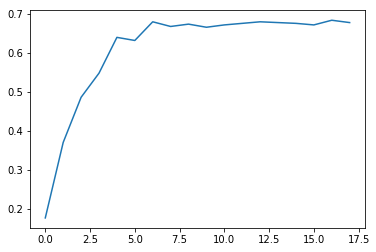

In [11]:
plt.plot(accuracies)

### Exercises:
* Add dropout
* Add more complexity to the model (RNN layers, other layers)
* Bidirectional RNN
* Use pretrained embeddings such as word2vec or GLOVE. Note that you can use: nn.Embedding.from_pretrained(...)